Test RMSE: 2973953.3872657027
Test R2: 0.5806003629376335

Feature Importances:
FP: 0.3933
AGE: 0.1870
FTA: 0.0336
FGM: 0.0304
MIN: 0.0278
ERROR: 0.0243
FG%: 0.0222
FT%: 0.0203
PTS: 0.0203
PF: 0.0183
DREB: 0.0183
FGA: 0.0183
L: 0.0176
BLK: 0.0164
AST: 0.0163
GP: 0.0163
W: 0.0155
TOV: 0.0155
REB: 0.0149
3P%: 0.0136
STL: 0.0132
FTM: 0.0120
OREB: 0.0096
DD2: 0.0094
3PA: 0.0080
3P: 0.0056
TD3: 0.0020
Salary: 0.0000
Age: 0.0000
Min: 0.0000
+/-: 0.0000
Id: 0.0000


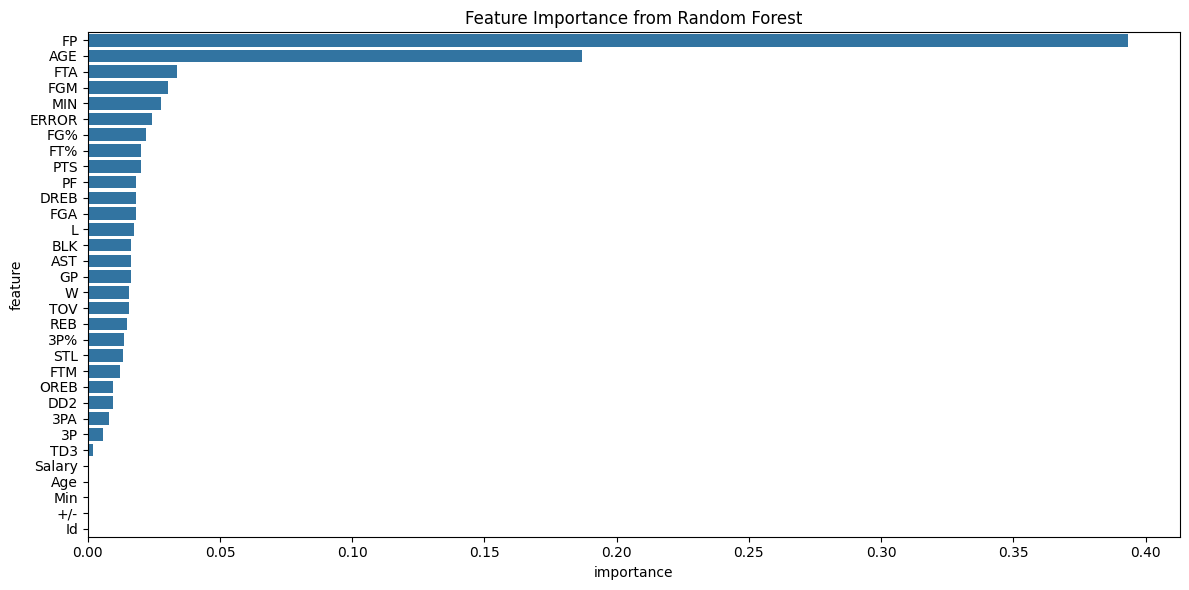


Salary Tier Summary:
  salary_tier          min           max          mean
0      Tier 1  5851437.485  2.641153e+07  1.012415e+07
1      Tier 2  3060314.430  5.850888e+06  4.249619e+06
2      Tier 3  1574985.750  3.059106e+06  2.251014e+06
3      Tier 4   213607.910  1.574777e+06  1.035223e+06

Top 20 Players with Predicted Salary & Tier:
          PLAYER  predicted_salary salary_tier
   Tracy Mcgrady      12117920.415      Tier 1
     Kobe Bryant      11502740.310      Tier 1
   Allen Iverson      13622647.570      Tier 1
Shaquille O'Neal      22527833.130      Tier 1
     Paul Pierce       5817320.445      Tier 2
   Dirk Nowitzki       5890363.835      Tier 1
      Tim Duncan      14535098.530      Tier 1
    Chris Webber      15114037.525      Tier 1
   Kevin Garnett      17905062.710      Tier 1
       Ray Allen      11542504.325      Tier 1
   Allan Houston      11313806.320      Tier 1
 Stephon Marbury      11758277.375      Tier 1
  Antawn Jamison      12227436.350      Tier 1

In [25]:

# -----------------------------
# NBA Player Salary Optimization Framework (Optimized, AGE removed, unnecessary columns removed)
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Load the dataset
# -----------------------------
df = pd.read_csv("All_Seasons_Clean.csv")  # Replace with your path

# -----------------------------
# 1a. Remove unnecessary columns
# -----------------------------
for col in ['Season', 'UNNAMED:_0', 'Unnamed:_0']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# -----------------------------
# 1b. Handle missing target
# -----------------------------
df = df.dropna(subset=['SALARY']).reset_index(drop=True)

# Keep player info for later
player_info = df[['PLAYER']].copy()  # Only Player needed now

# -----------------------------
# 2. Preprocessing
# -----------------------------
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('SALARY')
if 'Player_Comp_Share' in numeric_cols:
    numeric_cols.remove('Player_Comp_Share')

# # Remove AGE
# if 'AGE' in numeric_cols:
#     numeric_cols.remove('AGE')

X = df[numeric_cols].fillna(0)
y = df['SALARY']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 3. Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# -----------------------------
# 4. Random Forest Regression
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=200,  # fewer trees for speed
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -----------------------------
# 5. Evaluate model
# -----------------------------
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse}")
print(f"Test R2: {r2}")

# -----------------------------
# 6. Feature importance
# -----------------------------
feature_importances = pd.DataFrame({
    'feature': numeric_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Print feature importance for each feature
print("\nFeature Importances:")
for idx, row in feature_importances.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()

# -----------------------------
# 7. Predict salaries for all players
# -----------------------------
df['predicted_salary'] = rf.predict(scaler.transform(X))

# -----------------------------
# 8. Fast Tier Assignment (Percentiles)
# -----------------------------
bounds = np.percentile(df['predicted_salary'], [25, 50, 75])

def assign_tier(salary):
    if salary <= bounds[0]:
        return 'Tier 4'
    elif salary <= bounds[1]:
        return 'Tier 3'
    elif salary <= bounds[2]:
        return 'Tier 2'
    else:
        return 'Tier 1'

df['salary_tier'] = df['predicted_salary'].apply(assign_tier)

# Combine player info
tiered_players = pd.concat([
    player_info,
    df[['predicted_salary', 'salary_tier']]
], axis=1)

# Optional: Show salary ranges for each tier
tier_summary = tiered_players.groupby('salary_tier')['predicted_salary'].agg(['min','max','mean']).reset_index()
print("\nSalary Tier Summary:")
print(tier_summary)

# -----------------------------
# 9. Save results (only necessary columns)
# -----------------------------
print("\nTop 20 Players with Predicted Salary & Tier:")
print(tiered_players.head(20).to_string(index=False))
# tiered_players.to_csv("NBA_Player_Salary_Tiers_Optimized.csv", index=False)
# print("\nResults saved to NBA_Player_Salary_Tiers_Optimized.csv")

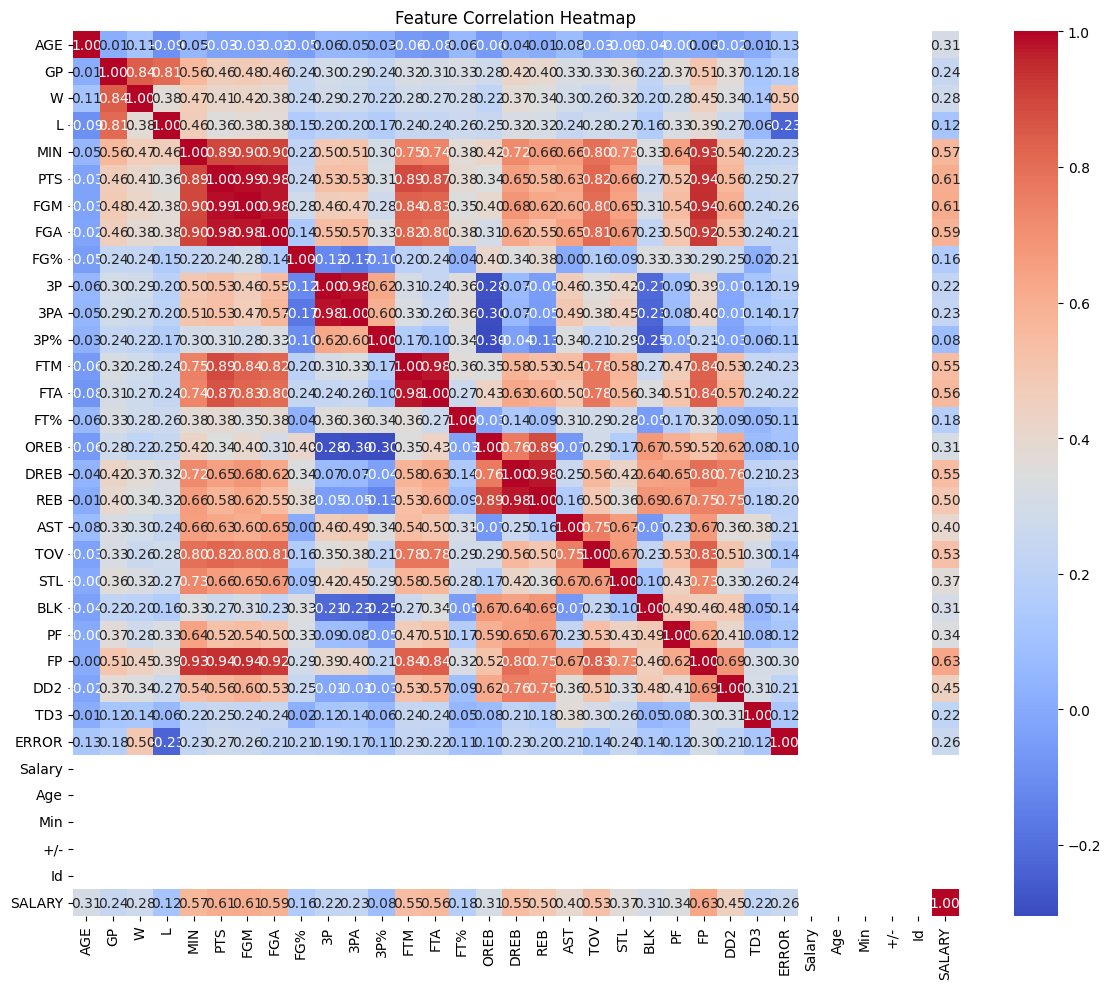

In [26]:
# make a coorelation heatmap of the features used in the model
plt.figure(figsize=(12,10))
corr = df[numeric_cols + ['SALARY']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()



In [27]:
# produce a list of attribute pairs with their coorelation values
corr_pairs = corr.unstack().reset_index()
corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs['Feature_1'] != corr_pairs['Feature_2']]
# Sort by absolute correlation value
corr_pairs['Abs_Correlation'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='Abs_Correlation', ascending=False).drop(columns=['Abs_Correlation'])

# filter Coorelation column for values > 0.8
high_corr = corr_pairs[corr_pairs['Correlation'].abs() > 0.8]
#print("\nHighly Correlated Feature Pairs (|Correlation| > 0.8):")
#print(high_corr.to_string(index=False))
# avoid repeating pairs (A,B) and (B,A)
seen = set()
unique_high_corr = []
for _, row in high_corr.iterrows():
    pair = tuple(sorted([row['Feature_1'], row['Feature_2']]))
    if pair not in seen:
        seen.add(pair)
        unique_high_corr.append(row)
print("\nUnique Highly Correlated Feature Pairs (|Correlation| > 0.8):")
for row in unique_high_corr:
    print(f"{row['Feature_1']} - {row['Feature_2']}: {row['Correlation']:.4f}")



Unique Highly Correlated Feature Pairs (|Correlation| > 0.8):
PTS - FGM: 0.9880
3P - 3PA: 0.9816
FGA - PTS: 0.9793
FGA - FGM: 0.9789
FTA - FTM: 0.9787
DREB - REB: 0.9754
FP - FGM: 0.9450
PTS - FP: 0.9402
MIN - FP: 0.9315
FP - FGA: 0.9219
MIN - FGA: 0.9001
FGM - MIN: 0.8970
PTS - MIN: 0.8946
PTS - FTM: 0.8913
REB - OREB: 0.8871
PTS - FTA: 0.8712
W - GP: 0.8439
FTA - FP: 0.8415
FTM - FP: 0.8363
FTM - FGM: 0.8360
TOV - FP: 0.8319
FTA - FGM: 0.8265
FTM - FGA: 0.8248
TOV - PTS: 0.8183
L - GP: 0.8140
FGA - TOV: 0.8119
TOV - FGM: 0.8041
FGA - FTA: 0.8014
FP - DREB: 0.8009


In [28]:
# run lasso regularization to identify important features
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)
lasso_importances = pd.DataFrame({
    'feature': numeric_cols,
    'importance': np.abs(lasso.coef_)
}).sort_values(by='importance', ascending=False)
print("\nLasso Feature Importances:")
for idx, row in lasso_importances.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")



Lasso Feature Importances:
FGM: 1947462.6878
AGE: 1399866.1715
DREB: 1085967.7286
FTA: 589307.9141
BLK: 444176.1654
PF: 418544.2678
AST: 345476.7722
L: 318290.5325
MIN: 261016.5459
STL: 254553.9237
TOV: 238711.3781
3P%: 167369.0606
DD2: 166838.5661
FG%: 145105.5164
FT%: 112049.2119
TD3: 111910.1646
3PA: 97333.9958
OREB: 87748.3566
ERROR: 75425.5653
W: 35272.6836
PTS: 9946.2144
Age: 0.0000
Salary: 0.0000
Min: 0.0000
+/-: 0.0000
REB: 0.0000
FP: 0.0000
GP: 0.0000
FTM: 0.0000
3P: 0.0000
FGA: 0.0000
Id: 0.0000


In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

# --- STEP 1: Base setup ---
df = pd.read_csv("All_Seasons_Clean.csv")

drop_cols = ['Season', 'UNNAMED:_0', 'Unnamed:_0', 'Salary', 'Age', '+/-', 'Id']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')
df = df.dropna(subset=['SALARY']).reset_index(drop=True)

# --- STEP 2: Handle correlated clusters ---

# --- 2a. Scoring Volume (keep FGM, drop others) ---
for col in ['PTS', 'FGA', 'FTA', 'FTM', 'FP', 'MIN']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# --- 2b. Rebounding (combine via PCA) ---
reb_cols = [c for c in ['REB', 'DREB', 'OREB'] if c in df.columns]
if len(reb_cols) >= 2:
    from sklearn.preprocessing import StandardScaler
    scaler_reb = StandardScaler()
    reb_scaled = scaler_reb.fit_transform(df[reb_cols])
    pca = PCA(n_components=1, random_state=42)
    df['Rebounding_PC1'] = pca.fit_transform(reb_scaled)
    df.drop(columns=reb_cols, inplace=True)

# --- 2c. Games Played Context (keep W) ---
for col in ['L', 'GP']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# --- 2d. Turnovers vs Attempts (keep TOV) ---
# already handled by removing FGA, FTA above

# --- STEP 3: Prepare data ---
if 'Player_Comp_Share' in df.columns:
    df.drop(columns=['Player_Comp_Share'], inplace=True)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('SALARY')

X = df[numeric_cols].fillna(0)
y = df['SALARY']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- STEP 4: Random Forest Regression ---
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- STEP 5: Evaluate ---
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Optimized RMSE: {rmse:.2f}")
print(f"Optimized R²: {r2:.4f}")

# --- STEP 6: Feature Importances ---
feature_importances = pd.DataFrame({
    'feature': numeric_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop Feature Importances:")
print(feature_importances.head(20).to_string(index=False))


Optimized RMSE: 2978988.87
Optimized R²: 0.5792

Top Feature Importances:
       feature  importance
           FGM    0.389085
           AGE    0.199103
Rebounding_PC1    0.059770
         ERROR    0.039713
           FG%    0.037901
           TOV    0.037289
           BLK    0.033508
           FT%    0.031668
             W    0.028466
            PF    0.027597
           AST    0.027245
           DD2    0.021845
           3P%    0.020334
           STL    0.019170
           3PA    0.014319
            3P    0.009146
           TD3    0.003839
           Min    0.000000


In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

# --- STEP 1: Base setup ---
df = pd.read_csv("All_Seasons_Clean.csv")

drop_cols = ['Season', 'UNNAMED:_0', 'Unnamed:_0', 'Salary', 'Age', '+/-', 'Id']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')
df = df.dropna(subset=['SALARY']).reset_index(drop=True)

# --- STEP 2: Handle correlated clusters ---

# --- 2a. Scoring Volume (combine via PCA) ---
scoring_cols = [c for c in ['PTS', 'FGM', 'FGA', 'FTA', 'FTM', 'FP', 'MIN'] if c in df.columns]
if len(scoring_cols) >= 2:
    scaler_score = StandardScaler()
    score_scaled = scaler_score.fit_transform(df[scoring_cols])

    pca_score = PCA(n_components=1, random_state=42)
    df['Scoring_PC1'] = pca_score.fit_transform(score_scaled)
    print(f"Scoring PCA Variance Explained: {pca_score.explained_variance_ratio_[0]:.3f}")

    # Drop original correlated columns
    df.drop(columns=scoring_cols, inplace=True)

# --- 2b. Rebounding (combine via PCA) ---
reb_cols = [c for c in ['REB', 'DREB', 'OREB'] if c in df.columns]
if len(reb_cols) >= 2:
    scaler_reb = StandardScaler()
    reb_scaled = scaler_reb.fit_transform(df[reb_cols])
    pca_reb = PCA(n_components=1, random_state=42)
    df['Rebounding_PC1'] = pca_reb.fit_transform(reb_scaled)
    print(f"Rebounding PCA Variance Explained: {pca_reb.explained_variance_ratio_[0]:.3f}")

    df.drop(columns=reb_cols, inplace=True)

# --- 2c. Games Played Context (keep W) ---
for col in ['L', 'GP']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# --- 2d. Turnovers vs Attempts (keep TOV) ---
# already handled by removing FGA, FTA above

# --- STEP 3: Prepare data ---
if 'Player_Comp_Share' in df.columns:
    df.drop(columns=['Player_Comp_Share'], inplace=True)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'SALARY' in numeric_cols:
    numeric_cols.remove('SALARY')

X = df[numeric_cols].fillna(0)
y = df['SALARY']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- STEP 4: Random Forest Regression ---
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- STEP 5: Evaluate ---
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"\nOptimized RMSE: {rmse:.2f}")
print(f"Optimized R²: {r2:.4f}")

# --- STEP 6: Feature Importances ---
feature_importances = pd.DataFrame({
    'feature': numeric_cols,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop Feature Importances:")
print(feature_importances.head(20).to_string(index=False))


Scoring PCA Variance Explained: 0.902
Rebounding PCA Variance Explained: 0.918

Optimized RMSE: 2983794.63
Optimized R²: 0.5778

Top Feature Importances:
       feature  importance
   Scoring_PC1    0.437749
           AGE    0.194142
Rebounding_PC1    0.049222
         ERROR    0.037307
           FG%    0.036448
           FT%    0.035396
           BLK    0.030912
            PF    0.026553
             W    0.025880
           AST    0.023544
           TOV    0.022362
           3P%    0.020008
           DD2    0.017425
           STL    0.017236
           3PA    0.013346
            3P    0.009004
           TD3    0.003466
           Min    0.000000


In [38]:
# -------------------------------------------------
# NBA Player Salary Prediction (Grid Search Tuned RF)
# -------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# --- STEP 1: Load and clean ---
df = pd.read_csv("All_Seasons_Clean.csv")

# Keep '+/-' this time
drop_cols = ['Season', 'UNNAMED:_0', 'Unnamed:_0', 'Salary', 'Id', 'Player_Comp_Share']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')
df = df.dropna(subset=['SALARY']).reset_index(drop=True)

# --- STEP 2: Handle multicollinearity clusters ---
# 2a. Scoring PCA (FGM, FGA, FTA, FTM, PTS, FP, MIN)
scoring_cols = [c for c in ['FGM', 'FGA', 'FTA', 'FTM', 'PTS', 'FP', 'MIN'] if c in df.columns]
if len(scoring_cols) >= 2:
    scaler_score = StandardScaler()
    score_scaled = scaler_score.fit_transform(df[scoring_cols])
    pca_scoring = PCA(n_components=1, random_state=42)
    df['Scoring_PC1'] = pca_scoring.fit_transform(score_scaled)
    print(f"Scoring PCA Variance Explained: {pca_scoring.explained_variance_ratio_[0]:.3f}")
    df.drop(columns=scoring_cols, inplace=True)

# 2b. Rebounding PCA (REB, DREB, OREB)
reb_cols = [c for c in ['REB', 'DREB', 'OREB'] if c in df.columns]
if len(reb_cols) >= 2:
    scaler_reb = StandardScaler()
    reb_scaled = scaler_reb.fit_transform(df[reb_cols])
    pca_reb = PCA(n_components=1, random_state=42)
    df['Rebounding_PC1'] = pca_reb.fit_transform(reb_scaled)
    print(f"Rebounding PCA Variance Explained: {pca_reb.explained_variance_ratio_[0]:.3f}")
    df.drop(columns=reb_cols, inplace=True)

# Drop duplicates or unneeded columns
for col in ['L', 'GP']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# --- STEP 3: Prepare data ---
if 'Player_Comp_Share' in df.columns:
    df.drop(columns=['Player_Comp_Share'], inplace=True)

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('SALARY')

X = df[numeric_cols].fillna(0)
y = df['SALARY']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- STEP 4: Random Forest with Grid Search ---
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\n🔍 Running Grid Search — this may take a few minutes...")
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\n✅ Best Parameters Found:")
print(grid.best_params_)
print(f"Best CV R²: {grid.best_score_:.4f}")

# --- STEP 5: Evaluate best model ---
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nOptimized Test RMSE: {rmse:.2f}")
print(f"Optimized Test R²: {r2:.4f}")

# --- STEP 6: Feature Importances ---
feature_importances = pd.DataFrame({
    'feature': numeric_cols,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\nTop Feature Importances:")
print(feature_importances.head(20).to_string(index=False))


Scoring PCA Variance Explained: 0.902
Rebounding PCA Variance Explained: 0.918

🔍 Running Grid Search — this may take a few minutes...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

✅ Best Parameters Found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
Best CV R²: 0.5969

Optimized Test RMSE: 2992441.83
Optimized Test R²: 0.5754

Top Feature Importances:
       feature  importance
   Scoring_PC1    0.203160
           AGE    0.150050
           TOV    0.097425
Rebounding_PC1    0.087405
           DD2    0.071328
           AST    0.054604
         ERROR    0.051141
            PF    0.037087
           BLK    0.034996
           FG%    0.034840
             W    0.033509
           STL    0.033137
           FT%    0.032598
           3PA    0.030769
           3P%    0.021979
            3P    0.021227
           TD3    0.004744
           Age    0.000000
           Min    0.000000
           +/-    0.

In [32]:
# --- Efficiency-Enhanced Random Forest ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# --- Load data ---
df = pd.read_csv("All_Seasons_Clean.csv")

drop_cols = ['Season','UNNAMED:_0','Unnamed:_0','Salary','+/-','Id']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')
df = df.dropna(subset=['SALARY']).reset_index(drop=True)

# --- Add efficiency ratios ---
if 'MIN' in df.columns:
    df['PTS_per_MIN'] = df['PTS'] / (df['MIN'] + 1e-5)
    df['REB_per_MIN'] = df['REB'] / (df['MIN'] + 1e-5)
    df['AST_per_MIN'] = df['AST'] / (df['MIN'] + 1e-5)
    df['STL_per_MIN'] = df['STL'] / (df['MIN'] + 1e-5)
    df['BLK_per_MIN'] = df['BLK'] / (df['MIN'] + 1e-5)

df['AST_to_TOV'] = df['AST'] / (df['TOV'] + 1e-5)
df['EFF'] = (df['PTS'] + df['REB'] + df['AST'] + df['STL'] + df['BLK']
             - (df['FGA'] - df['FGM']) - (df['FTA'] - df['FTM']) - df['TOV'])

# --- PCA for Rebounding ---
reb_cols = [c for c in ['REB','DREB','OREB'] if c in df.columns]
if len(reb_cols) >= 2:
    scaler_reb = StandardScaler()
    reb_scaled = scaler_reb.fit_transform(df[reb_cols])
    pca = PCA(n_components=1, random_state=42)
    df['Rebounding_PC1'] = pca.fit_transform(reb_scaled)
    print(f"Rebounding PCA Variance Explained: {pca.explained_variance_ratio_[0]:.3f}")
    df.drop(columns=reb_cols, inplace=True)

# --- Prepare train/test ---
if 'Player_Comp_Share' in df.columns:
    df.drop(columns=['Player_Comp_Share'], inplace=True)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('SALARY')
X = df[numeric_cols].fillna(0)
y = df['SALARY']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Model ---
rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# --- Evaluate ---
y_pred = rf.predict(X_test)
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.0f}")
print(f"Test R²: {r2_score(y_test, y_pred):.3f}")


Rebounding PCA Variance Explained: 0.918
Test RMSE: 2964207
Test R²: 0.583


In [36]:
# --- XGBoost Version ---
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd, numpy as np

# assume df prepared exactly as in your best PCA pipeline
df = pd.read_csv("All_Seasons_Clean.csv")
drop_cols = ['Season','UNNAMED:_0','Unnamed:_0','Salary','+/-','Id']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')
df = df.dropna(subset=['SALARY']).reset_index(drop=True)

# numeric setup
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('SALARY')
X = df[numeric_cols].fillna(0)
y = df['SALARY']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.0f}")
print(f"XGBoost R²: {r2_score(y_test, y_pred):.3f}")

# feature importance
import pandas as pd
feat_imp = pd.DataFrame({
    "feature": numeric_cols,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)
print("\nTop XGBoost Feature Importances:")
print(feat_imp.head(15).to_string(index=False))


XGBoost RMSE: 1887056
XGBoost R²: 0.831

Top XGBoost Feature Importances:
          feature  importance
Player_Comp_Share    0.293659
               FP    0.235256
              FTA    0.047936
              AGE    0.047503
              FGM    0.036093
              FGA    0.028763
             DREB    0.022612
              TD3    0.022403
              PTS    0.020822
                L    0.018530
              FTM    0.017824
              TOV    0.015752
            ERROR    0.015279
              MIN    0.014887
              REB    0.014410


In [37]:
# --- XGBoost Version ---
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd, numpy as np

# --- Load & Clean Data ---
df = pd.read_csv("All_Seasons_Clean.csv")

drop_cols = ['Season', 'UNNAMED:_0', 'Unnamed:_0', 'Salary', '+/-', 'Id']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

# Drop 'Player_Comp_Share' if it exists
if 'Player_Comp_Share' in df.columns:
    df.drop(columns=['Player_Comp_Share'], inplace=True)

df = df.dropna(subset=['SALARY']).reset_index(drop=True)

# --- Feature Setup ---
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('SALARY')
X = df[numeric_cols].fillna(0)
y = df['SALARY']

# --- Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- XGBoost Model ---
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

# --- Evaluate ---
y_pred = xgb.predict(X_test)
print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.0f}")
print(f"XGBoost R²: {r2_score(y_test, y_pred):.3f}")

# --- Feature Importance ---
feat_imp = pd.DataFrame({
    "feature": numeric_cols,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\nTop XGBoost Feature Importances:")
print(feat_imp.head(15).to_string(index=False))


XGBoost RMSE: 2956052
XGBoost R²: 0.586

Top XGBoost Feature Importances:
feature  importance
     FP    0.282850
    FGM    0.105154
    AGE    0.064840
    FGA    0.039904
    FTA    0.039292
    MIN    0.039281
    PTS    0.034967
   DREB    0.032147
    BLK    0.029437
    TD3    0.027908
    DD2    0.023158
  ERROR    0.022577
    TOV    0.022450
    STL    0.022200
     PF    0.022053
